# Convoultional Neural Network : CIFAR-10 (pytorch)
- Here, the following are implemented,
  1) Convolution neural network with pytorch
  2) Training neural networks with above implementation



In [1]:
import torch
import torchvision.transforms as transforms

import numpy as np
from utils import *
from custom_cnn import *

## Set Random Seed

In [2]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Use GPU

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Data Preprocessing
### CIFAR-10 dataset
We will use CIFAR-10 dataset
- The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.
- We will use 10000 training images and 1000 test images as we did in HW 2-1.


### Define transformation
To augment the dataset, we will use torchvision.transforms.Compose function.

Various data augmentation techniques (resize, crop, flip, contrast, ...) can be used.

Here, we will use simple data augmentations:



In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


## Define custom dataset and loader

In [5]:

from torch.utils.data import Dataset, DataLoader

class CustomCIFAR10 (Dataset):
    def __init__(self,  mode, transform):
        self.mode = mode
        self.transform = transform

        raw_data= get_CIFAR10_data(subtract_mean=False)
        if self.mode == 'train':
            # (10000, 32, 32, 3), (10000,)
            self.data, self.target = raw_data["X_train"],raw_data["y_train"]
        elif self.mode == 'test':
            # (1000, 32, 32, 3), (1000,)
            self.data, self.target = raw_data["X_test"],raw_data["y_test"]
        else:
            raise NotImplementedError

        assert len(self.data) == len(self.target), "Number of data and target should be same!"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # dtype of image and label is numpy
        image, label = self.data[idx], self.target[idx]
        image = Image.fromarray(image.astype(np.uint8))

        if self.transform is not None:
            image = self.transform(image)

        return image, label

def CIFAR10_dataloader(batch_size, train_transform, test_transform):

        train_dataset = CustomCIFAR10(mode='train', transform=train_transform)
        test_dataset = CustomCIFAR10(mode='test', transform=test_transform)

        train_datalader = DataLoader(train_dataset,
                                     batch_size=batch_size,
                                     shuffle=True)

        test_datalader = DataLoader(test_dataset,
                                     batch_size=1,
                                     shuffle=False)
        classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

        return train_datalader, test_datalader, classes


In [6]:
# data loader
batch_size = 32
trainloader, testloader, classes  = CIFAR10_dataloader(batch_size,transform_train,transform_test)

## Visualize training images

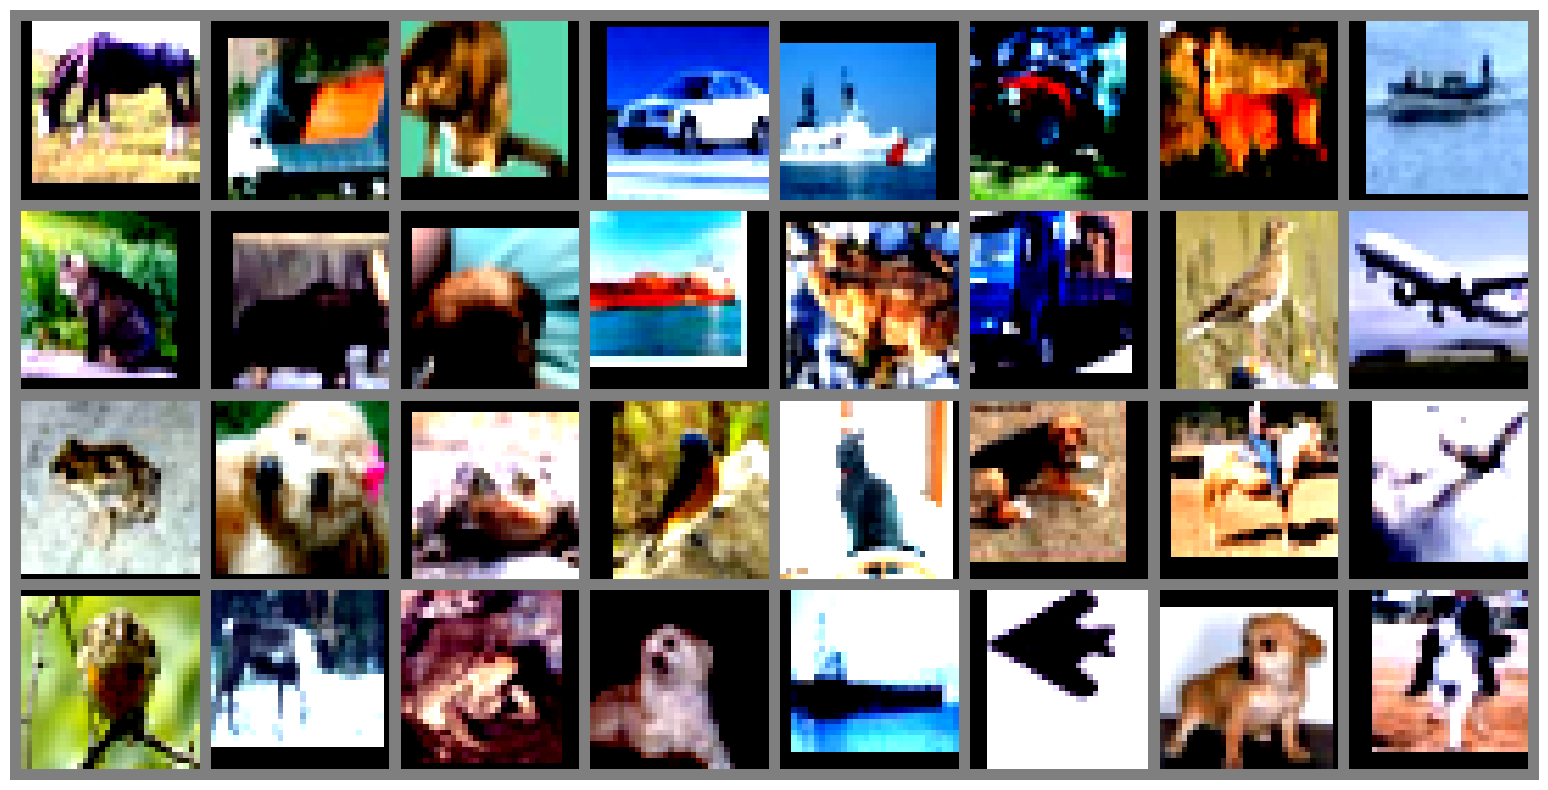

In [7]:
iterator = iter(trainloader)
sample_image, sample_label = next(iterator)

import torchvision
imshow(torchvision.utils.make_grid(sample_image,8))

### pytorch_CNN
- The CNN is composed of the following blocks and layers,
    - Feature Extraction Layer Block
      - first layer: Conv, Batchnorm, Relu, Max pool
      - second layer:  Conv, Batchnorm, Relu, Max pool
    - Classification Layer Block
      - first layer: Linear, Relu
      - second layer: Linear, Relu
      - last layer: Linear


In [8]:
num_classes=len(classes)
net = pytorch_CNN(num_classes)
net.to(device)

pytorch_CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1024, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=4096, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
  )
  (out): Linear(in_features=4096, out_features=10, bias=True)
)

## Setting Hyperparameters
Here, we manually set hyperparameters(epochs, lr, ..) that are used for training the model. Hyper-parameters are one of the important factor to train a model up to targeting performance.

In [9]:
epochs = 20
learning_rate=0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

### Let's training and check the results

You will achieve greater than 55% acccuracy on the training set.

In [10]:
import time
start = time.time()
start_epoch = 0


tr_acc = []
tr_loss = []
te_acc = []
te_loss = []

for epoch in range(epochs):
    net.train()
    train_loss = 0
    train_correct = 0
    test_correct = 0

    for batch_idx, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = outputs.max(1)
        train_correct += predicted.eq(labels).sum().item()

    tr_loss_i = train_loss/len(trainloader)
    tr_acc_i = 100.*train_correct/len(trainloader.dataset)

    # eval
    net.eval()
    test_loss = 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(testloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)

            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_correct += predicted.eq(labels).sum().item()

    te_loss_i = test_loss/len(testloader)
    te_acc_i = 100.*test_correct/len(testloader.dataset)

    print(f'Epoch: {epoch}, Training loss: {tr_loss_i:.3f}, Training acc: {tr_acc_i:.3f},  Test loss: {te_loss_i:.3f}, Test acc : {te_acc_i:.3f}')

    tr_loss.append( tr_loss_i )
    tr_acc.append ( tr_acc_i )
    te_loss.append(te_loss_i )
    te_acc.append(te_acc_i )


#Time Calculation

finish = time.time() - start
temp_log = "Time Elapse: %s" %(format_time(finish))
print(temp_log)

Epoch: 0, Training loss: 1.873, Training acc: 30.820,  Test loss: 1.612, Test acc : 42.100
Epoch: 1, Training loss: 1.617, Training acc: 40.450,  Test loss: 1.465, Test acc : 46.500
Epoch: 2, Training loss: 1.549, Training acc: 43.470,  Test loss: 1.437, Test acc : 48.100
Epoch: 3, Training loss: 1.467, Training acc: 46.400,  Test loss: 1.329, Test acc : 51.000
Epoch: 4, Training loss: 1.424, Training acc: 47.590,  Test loss: 1.324, Test acc : 52.700
Epoch: 5, Training loss: 1.369, Training acc: 49.700,  Test loss: 1.270, Test acc : 54.500
Epoch: 6, Training loss: 1.320, Training acc: 51.890,  Test loss: 1.290, Test acc : 51.900
Epoch: 7, Training loss: 1.301, Training acc: 52.470,  Test loss: 1.275, Test acc : 55.000
Epoch: 8, Training loss: 1.259, Training acc: 54.310,  Test loss: 1.196, Test acc : 59.600
Epoch: 9, Training loss: 1.226, Training acc: 55.430,  Test loss: 1.149, Test acc : 59.300
Epoch: 10, Training loss: 1.209, Training acc: 56.050,  Test loss: 1.157, Test acc : 60.80

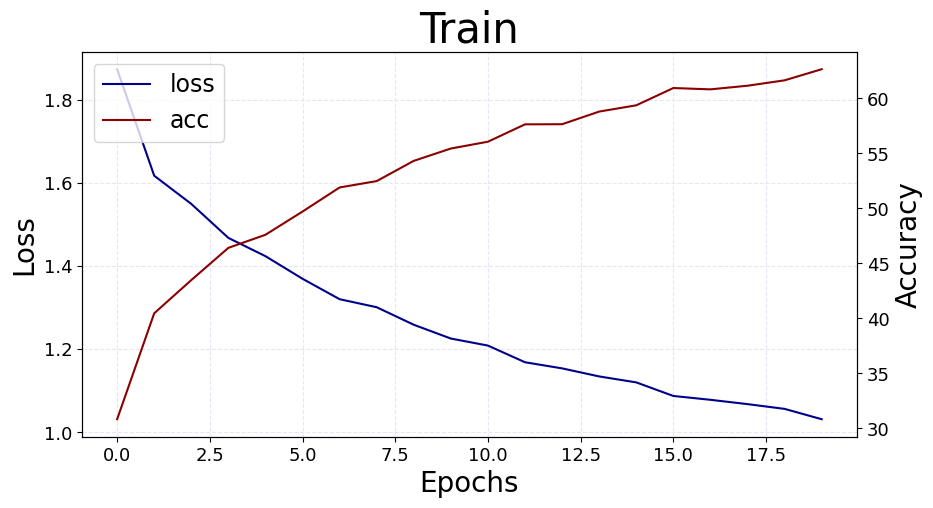

In [11]:
loss_and_acc(tr_acc, tr_loss, 'Train')

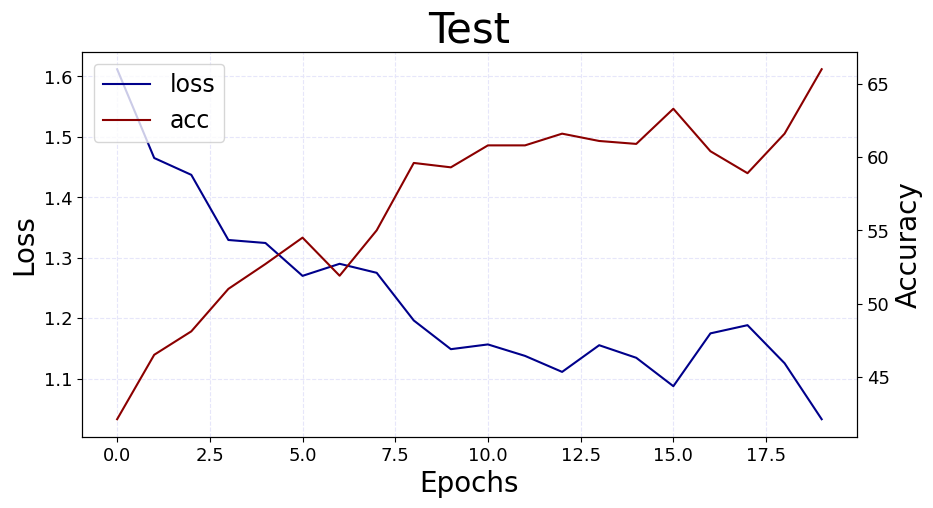

In [12]:
loss_and_acc(te_acc, te_loss, 'Test')

In [13]:
print('Best test accuracy :', np.max(te_acc), 'at epoch', np.argmax(te_acc))

Best test accuracy : 66.0 at epoch 19




---
In this part, it was possible to train a convolutional neural network
implemented using PyTorch. The results obtained show a training accuracy of 62.64% and test accuracy of 66% (best case) and the training for 20 epochs took about 1 minute which is more effcient than the NumPy based implementation. This is indicative of the computational efficiency of standard deep learning libraries like PyTorch.


---



**References**

 *CS231N: Deep Learning for Computer Vision (2023),* Stanford University CS231n: Deep Learning for Computer Vision. Available at: http://cs231n.stanford.edu.html

